In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from script.NeuralNets.Networks import SequentialNN
from script.ZonotopePropagation.Zonotope import Zonotope
from script.ZonotopePropagation.ZonotopePropagation import ZonotopePropagator
from script.DHOV.Sampling.SamplingStrategy import SamplingStrategy
from script.DHOV.Sampling.PerGroupSamplingStrategy import PerGroupSamplingStrategy
from script.DHOV.Sampling.PropagateSamplingStrategy import UniformSamplingStrategy
from script.settings import data_type, device

from script.DHOV.Sampling.ZonotopeSamplingStrategy import ZonotopeSamplingStrategy as ZS

import script.DHOV.DataSampling as ds

import numpy as np


In [2]:
# input_dim, hidden_dim1, hidden_dim2, ..., output_dim
model = SequentialNN([2, 2, 2, 2])
model

SequentialNN(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=2, bias=True)
)

In [3]:
with torch.no_grad():
    model[0].weight = nn.Parameter(torch.tensor([[1, 1], [1, -1.]], dtype=data_type))
    model[0].bias   = nn.Parameter(torch.zeros(2, dtype=data_type))

    model[2].weight = nn.Parameter(torch.tensor([[1, 1], [1, -1.]], dtype=data_type))
    model[2].bias   = nn.Parameter(torch.tensor([-0.5, 0], dtype=data_type))

    model[4].weight = nn.Parameter(torch.tensor([[-1, 1], [0, 1.]], dtype=data_type))
    model[4].bias   = nn.Parameter(torch.tensor([3., 0], dtype=data_type))

In [4]:
zp = ZonotopePropagator(model)

In [5]:
lbs = torch.tensor([-1., -1], dtype=data_type)
ubs = torch.tensor([1., 1], dtype=data_type)
z = zp.propagate(lbs, ubs, dtype=data_type)

print(z.center)
z.generators.T

propagating linear layer
propagating ReLU layer
propagating linear layer
propagating ReLU layer
propagating linear layer
tensor([2.7188, 0.5000], dtype=torch.float64, grad_fn=<AddBackward0>)


tensor([[-0.6250,  0.5000, -0.0625, -0.5625, -0.4688,  0.5000],
        [ 0.0000,  0.5000,  0.2500, -0.2500,  0.0000,  0.5000]],
       dtype=torch.float64, grad_fn=<PermuteBackward0>)

# Sampling Methods

In [6]:
def sample_direction(d, z):
    """
    Finds point that maximizes d^T x for x in zonotope z.

    Just linearly transforms the zonotope in direction d,
    then calculates the maximizer for that 1d zonotope and 
    applies that maximizer to the original zonotope z.

    args:
        d - an (n x 1) tensor for an n dimensional zonotope z 
            the direction to maximize in
        z - the zonotope to maximize over

    returns:
        p_out - (n x 1) tensor, point in z that maximizes d^T x for x in z
    """
    z_sample = zp.propagate_linear(d.T, torch.tensor([0.], dtype=data_type), z)
    x_hat = torch.where(z_sample.generators > 0, torch.tensor(1., dtype=data_type), torch.tensor(-1., dtype=data_type))
    p_out = x_hat.T @ z.generators + z.center

    return p_out.reshape(-1, 1)

In [7]:
def sample_directions(D, z):
    """
    Finds points that maximize d^T x for x in zonotope z and d = D[i,:]

    returns:
        P - (n x d) one column for each sample point
    """
    n_samples = D.shape[0]
    z_sample = zp.propagate_linear(D, torch.zeros(n_samples, dtype=data_type), z)
    X_hat = torch.where(z_sample.generators > 0, torch.tensor(1., dtype=data_type), torch.tensor(-1., dtype=data_type))

    P = z.generators.T @ X_hat + z.center.reshape(-1, 1)
    return P

## Sampling Single Points

In [8]:
n_samples = 100
dirs = torch.randn((2, n_samples), dtype=data_type)
ps = []
for i in range(n_samples):
    d = dirs[:,i].reshape(-1, 1)
    p = sample_direction(d, z)
    ps.append(p)

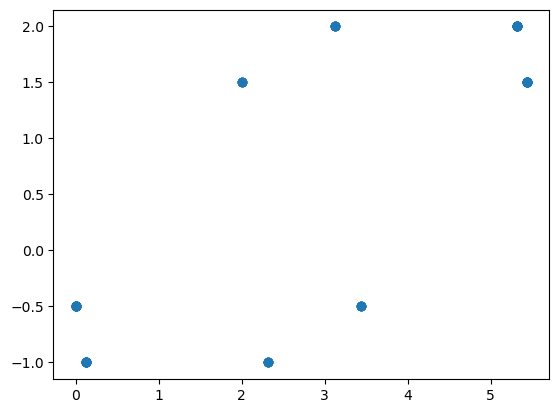

In [9]:
xs = [p[0,0].detach().numpy() for p in ps]
ys = [p[1,0].detach().numpy() for p in ps]

plt.scatter(xs, ys)

## Simultaneously Sampling Many Points

In [10]:
D = torch.randn((100, 2), dtype=data_type)

P = sample_directions(D, z)

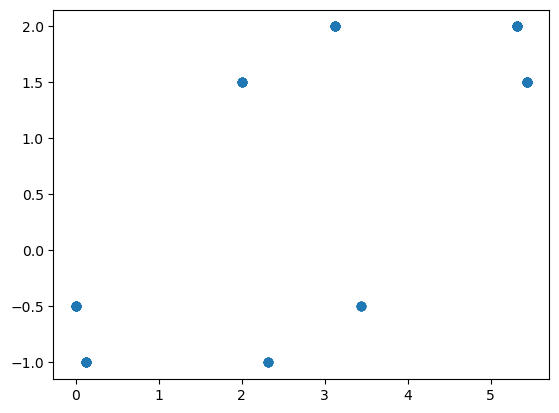

In [11]:
xs = P[0,:].detach().numpy()
ys = P[1,:].detach().numpy()

plt.scatter(xs, ys)

Now integrated into the `Zonotope` class

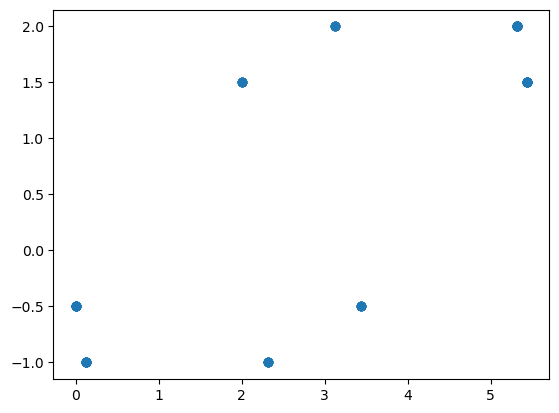

In [12]:
P = z.sample_boundary()

xs = P[0,:].detach().numpy()
ys = P[1,:].detach().numpy()

plt.scatter(xs, ys)

In [13]:
z[0:2]

Zonotope(center=tensor([2.7188, 0.5000], dtype=torch.float64, grad_fn=<SliceBackward0>), generators=tensor([[-0.6250,  0.0000],
        [ 0.5000,  0.5000],
        [-0.0625,  0.2500],
        [-0.5625, -0.2500],
        [-0.4688,  0.0000],
        [ 0.5000,  0.5000]], dtype=torch.float64, grad_fn=<SliceBackward0>))

# Implement SamplingStrategy Interface

In [42]:
class ZonotopeSamplingStrategy(SamplingStrategy):

    def __init__(self, *args, use_intermediate_bounds=True, **kwargs):
        super().__init__(*args, **kwargs)

        in_lbs = self.center - self.eps
        in_ubs = self.center + self.eps
        self.zono = Zonotope.from_bounds(in_lbs, in_ubs, shape=(len(in_lbs),), dtype=data_type)
        self.use_intermediate_bounds = use_intermediate_bounds

        self.sampling_eps = self.eps

    def sampling_by_round(self, affine_w, affine_b, group_indices, gurobi_model, current_layer_index, bounds_affine_out,
                          bounds_layer_out, list_of_icnns):
        """
        Use this method to sample data points for one layer for all groups.
        Args:
         list_of_icnns:
            affine_w: the weight matrix of the current layer
            affine_b: the bias vector of the current layer
            group_indices: the index of the neuron to be sampled, for all groups
            gurobi_model: the gurobi model to be used for sampling
            current_layer_index: the index of the current layer
            bounds_affine_out: the bounds of the affine output space of the all layers
            bounds_layer_out: the bounds of the activation output space of the all layers

        Returns: list of tuple of included_space, ambient_space

        """
        z = ZonotopePropagator.propagate_linear(affine_w, affine_b, self.zono)

        
        current_bounds_affine_out = bounds_affine_out[current_layer_index]
        current_bounds_layer_out  = bounds_layer_out[current_layer_index]

        n_included, n_ambient = self.get_num_of_samples()
        included_samples = []
        ambient_samples = []
        for group in group_indices[current_layer_index]:
            z_group = z[group]
            P = z_group.sample_boundary(n_samples=n_included)
            #samples = torch.zeros((n_included, affine_b.shape[0]), dtype=data_type)
            #samples[:,group] = nn.functional.relu(P.T)
            samples = nn.functional.relu(P.T)
            included_samples.append(samples)

            new_amb_space = ds.samples_uniform_over(torch.zeros((n_ambient, affine_b.shape[0])), n_ambient,
                                                        current_bounds_layer_out,
                                                        padding=self.sampling_eps, keep_samples=False)
            new_amb_space = torch.index_select(new_amb_space, 1, torch.tensor(group))

            ambient_samples.append(new_amb_space)

        lb = current_bounds_affine_out[0] if self.use_intermediate_bounds else None
        ub = current_bounds_affine_out[1] if self.use_intermediate_bounds else None
        self.zono = ZonotopePropagator.propagate_relu(z, lb=lb, ub=ub)

        return included_samples, ambient_samples


In [15]:
center = 0.5 * (lbs + ubs)
eps = 0.5 * (ubs - lbs)

# group_indices is of type list of (list of indices per group) per layer
group_indices = [[[0, 1], [1, 0]], [[0,1], [1,0]], [[0,1], [1,0]]]
current_layer_index = 0
simple_bounds_affine_out, simple_bounds_layer_out = model.calculate_box_bounds([lbs, ubs])

In [16]:
zono_strategy = ZonotopeSamplingStrategy(center, eps, model, sample_count=200, use_intermediate_bounds=False)

current_layer_index = 0
zono_strategy.sampling_by_round(model[0].weight, model[0].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])

current_layer_index = 1
zono_strategy.sampling_by_round(model[2].weight, model[2].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])

current_layer_index = 2
included_samples, ambient_samples = zono_strategy.sampling_by_round(model[4].weight, model[4].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])

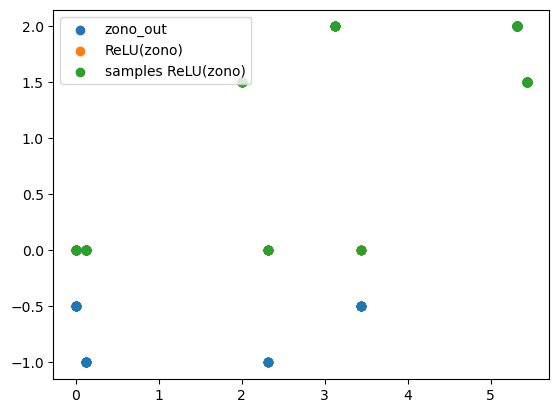

In [17]:
P = z.sample_boundary()

xs = P[0,:].detach().numpy()
ys = P[1,:].detach().numpy()

plt.scatter(xs, ys, label="zono_out")

plt.scatter(np.maximum(0, xs), np.maximum(0, ys), label="ReLU(zono)")

xs = included_samples[0][:,0].detach().numpy()
ys = included_samples[0][:,1].detach().numpy()

plt.scatter(xs, ys, label="samples ReLU(zono)")
plt.legend(loc='upper left')

Sampling with zonotopes seems to work, if we set `use_intermediate_bounds=True`, we get a little different results, but that is to be expected, if different bounds are used throughout.

In [18]:
zs = ZS(center, eps, model, sample_count=200, use_intermediate_bounds=True)

current_layer_index = 0
zs.sampling_by_round(model[0].weight, model[0].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])

current_layer_index = 1
zs.sampling_by_round(model[2].weight, model[2].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])

current_layer_index = 2
included_samples, ambient_samples = zs.sampling_by_round(model[4].weight, model[4].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])

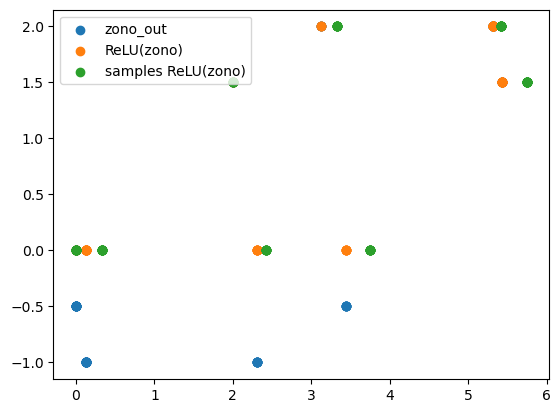

In [19]:
P = z.sample_boundary()

xs = P[0,:].detach().numpy()
ys = P[1,:].detach().numpy()

plt.scatter(xs, ys, label="zono_out")

plt.scatter(np.maximum(0, xs), np.maximum(0, ys), label="ReLU(zono)")

xs = included_samples[0][:,0].detach().numpy()
ys = included_samples[0][:,1].detach().numpy()

plt.scatter(xs, ys, label="samples ReLU(zono)")
plt.legend(loc='upper left')

In [43]:
model = SequentialNN([2, 4, 4, 4])
model

SequentialNN(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=4, bias=True)
)

In [44]:
center = 0.5 * (lbs + ubs)
eps = 0.5 * (ubs - lbs)[0]

# group_indices is of type list of (list of indices per group) per layer
group_indices = [[[0, 1], [2, 3]], [[0,1], [2, 3]], [[0,1], [2, 3]]]
current_layer_index = 0
simple_bounds_affine_out, simple_bounds_layer_out = model.calculate_box_bounds([lbs, ubs])

zono_strategy = ZonotopeSamplingStrategy(center, eps, model, sample_count=200, use_intermediate_bounds=False)

current_layer_index = 0
zono_strategy.sampling_by_round(model[0].weight, model[0].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])

current_layer_index = 1
zono_strategy.sampling_by_round(model[2].weight, model[2].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])

current_layer_index = 2
included_samples, ambient_samples = zono_strategy.sampling_by_round(model[4].weight, model[4].bias, group_indices, None, current_layer_index, simple_bounds_affine_out, simple_bounds_layer_out, [])